# Train Logistic Regression model on kss events


Train and evaluate against training set

This is to verify the algorithms are working.
Validation is done manually and will come later.


Logistic Regression will also be the baseline model for comparing other models


In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression

from config import Project
from src.audio import Audio
from src.kss_df import make_kss_df_cls
from src.model_plot import ModelPlot
from src.model_wrapper import get_SKLearnWrapper
from src.shared_params import make_shared_params_cls
from src.training_loader import make_training_loader
from src.transformers.sliding_window import SlidingWindow

In [2]:
# Setup

# Import Korean Fonts
k_prop = Project.setup_font()

# Configure matplotlib
plt = Project.setup_plot()

# Display handler with some nice helpers
disp = Project.setup_display()


# disp examples
# disp(IPython.display.Audio('./data/korean-single-speaker/kss/1/1_0000.wav'))
# disp_file_source('marker_df.py', label='marker_df')
# disp_audio_file('./data/korean-single-speaker/kss/1/1_0000.wav', label='1_0000.wav')

## Load Training Data

In [3]:
trn_loader = make_training_loader('xy_trn_rms', Project.path.MODEL)
X_train, y_train, _ = trn_loader.load()

disp.obj(X_train, label='X')
disp.obj(y_train, label='y')
disp.obj((X_train.shape, np.mean(X_train)), label='X shape, mean' )
disp.obj((y_train.shape, np.mean(y_train)), label='y shape, mean')

X

array([7.2832445e-05, 8.1853534e-05, 8.1345970e-05, ..., 1.6493888e-03,
       1.9856682e-03, 2.1819461e-03], dtype=float32)

y

array([False, False, False, ..., False, False, False])

X shape, mean

((8895,), 0.23018801)

y shape, mean

((8895,), 0.818999437886453)

## Train Model and Save: SVC (Support Vector Classifier)

We wrap the model with the necessary transformations included in the wrapper.

In [4]:
sliding_window = SlidingWindow(window=128, offset_percent=0.75)
disp.obj(sliding_window, label='SlidingWindow')

model_id = 'logr'
logr = LogisticRegression(C=2.0, tol=0.01, max_iter=1000)

SlidingWindow

SlidingWindow(offset_percent=0.75, window=128)

In [5]:
sklw = get_SKLearnWrapper(model_id, logr, Project.path.MODEL, transformer=sliding_window)

# import logging
# _sw = sklw.transformer.transformer
# _sw.log.setLevel(logging.DEBUG)
# _sw.fit_transform(X_train, y_train)

In [6]:
print(X_train.size)
print(y_train.size)

8895
8895


In [7]:
sklw.fit(X_train, y_train)

ModelWrapper[INFO]: fitting using model: LogisticRegression(C=2.0, max_iter=1000, tol=0.01)
SlidingWindow[INFO]: np sliding window shape: (9087, 128)
BaseTransform[INFO]: transformed X, y shapes: (8895, 128), (8895,)


LogisticRegression(C=2.0, max_iter=1000, tol=0.01)

In [8]:
# Set up the model for saving

sklw.save()
sklw_loaded = sklw.load()
sklw_saved = get_SKLearnWrapper(model_id, sklw_loaded, Project.path.MODEL, transformer=sliding_window)

VersionedSaver[INFO]: Saving model to: /Users/dev/Projects/korean-ml/data/model/logr.0.0.model


## Evaluate Training

Evaluate the training data by seeing if our trained model will predict close to the data it was trained on.

Validation will come later

This is just to make sure our Model trained correctly. It might have overfit, but we don't care yet.

In [9]:
y_train_pred = sklw_saved.predict(X_train)
shared_params = make_shared_params_cls(Project.path.MODEL)().load()

SlidingWindow[INFO]: np sliding window shape: (9087, 128)
BaseTransform[INFO]: transformed X, y shapes: (8895, 128), (8895,)


In [10]:
# remove kss_ids from params just to keep things a bit cleaner
kss_ids = shared_params['kss']['trn_ids']
print(kss_ids)
audio_params = shared_params['audio']
# iterate over each kss_id, find the audio file, load it and return it's squeezed rms
KssDf = make_kss_df_cls(Project.path.TEXTGRID, Project.path.KSSCSV)
x_rms = np.concatenate([Audio(KssDf(id).audio_path, **audio_params).rms.squeeze() for id in kss_ids])

/Users/dev/Projects/korean-ml/venv/lib/python3.9/site-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(
Audio[INFO]: a.to_rms size: 2431, reduction factor 2430.0
Audio[WARNING]: Modifying input wav from size 175173 to 175232
Audio[INFO]: change in number of samples: 59 [should be less than hop length: 64]
Audio[INFO]: a.to_rms size: 2739, reduction factor 2738.0


['1_0000', '1_0001', '1_0002', '1_0003', '1_0004']


Audio[WARNING]: Modifying input wav from size 77573 to 77632
Audio[INFO]: change in number of samples: 59 [should be less than hop length: 64]
Audio[INFO]: a.to_rms size: 1214, reduction factor 1213.0
Audio[WARNING]: Modifying input wav from size 101762 to 101824
Audio[INFO]: change in number of samples: 62 [should be less than hop length: 64]
Audio[INFO]: a.to_rms size: 1592, reduction factor 1591.0
Audio[WARNING]: Modifying input wav from size 58741 to 58752
Audio[INFO]: change in number of samples: 11 [should be less than hop length: 64]
Audio[INFO]: a.to_rms size: 919, reduction factor 918.0


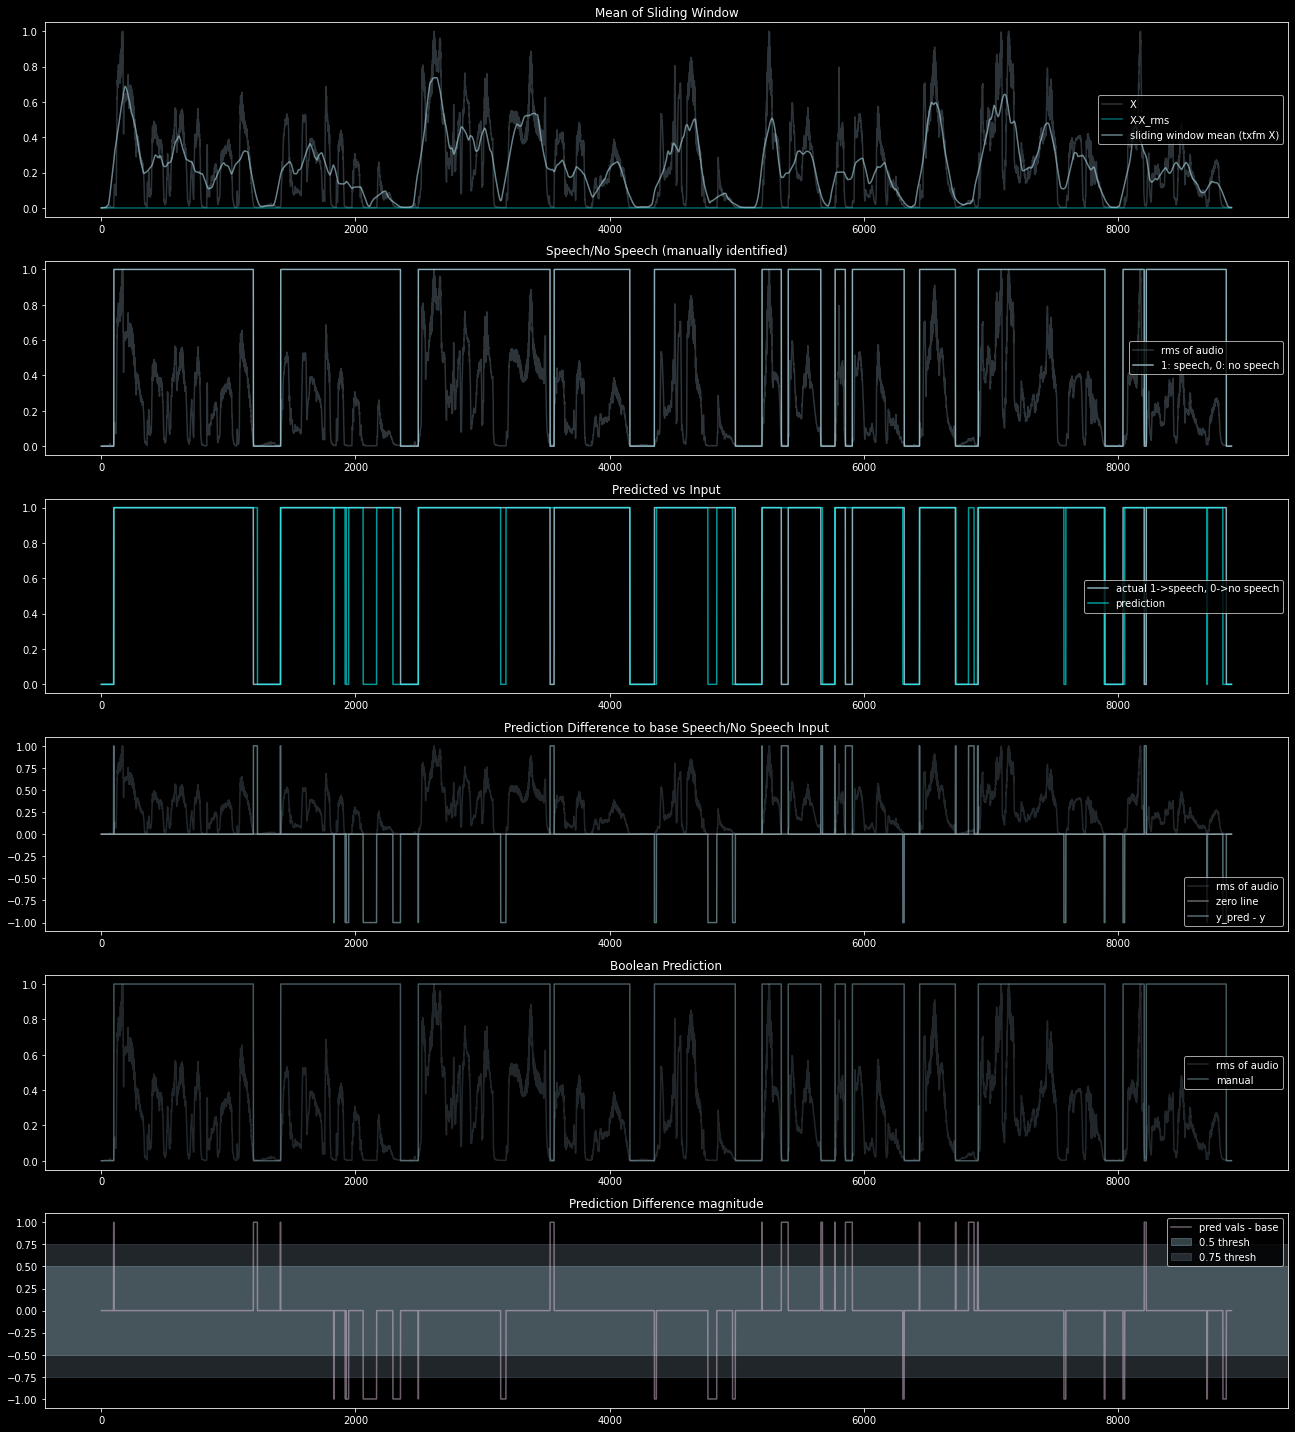

In [11]:
ModelPlot.plot(X_train, y_train, y_train_pred, x_rms, sliding_window)